# The Cross Entropy Method: a Tutorial

## Tutorial contents
* [Background](#Background)
* [The cem package](#The-cem-package)
* [Toy example](#Toy-example:-the-tail-of-a-uniform-distribution)
    * [Sampling (constant threshold)](#Sampling-below-a-constant-threshold)
    * [Sampling (quantile threshold)](#Sampling-below-a-quantile-threshold)
    * [Optimization](#Optimization)
* [Example](#Cross-entropy-sampler-for-risk-averse-reinforcement-learning): sample "difficult" environment-conditions for risk-averse reinforcement learning

## Background

The [Cross Entropy Method](http://web.mit.edu/6.454/www/www_fall_2003/gew/CEtutorial.pdf) (CE or CEM) is an approach for optimization or rare-event sampling.

### CEM for rare-event sampling
#### A motivating example: sample the most difficult times and roads for self-driving training
Let's say that we want to train an autonomous car. A-priory, we have no preference to train in certain hours or roads more than others; so by default, we send our car in hours and roads sampled uniformly.
However, we do prefer to focus the learning on challenging driving conditions. We can use the CEM to sample the more challenging hours and roads, even if we don't know in advance which ones they are.

#### Formalizing the problem
For simplicity, let's focus on sampling of driving hours.
First, we define the original distribuion of hours $x \sim D=U([0,1))$ (up to a $\times 24$ factor).
To allow modification of $D$, we rewrite it as an instance of a parametric family of distributions, e.g., $D = D_{\phi_0} = Beta({\phi_0})$, where $\phi_0=(1,1)$ and [$Beta(1,1)$](https://en.wikipedia.org/wiki/Beta_distribution) is indeed the uniform distribution.
We denote by $R(x)$ the score function: in our example, it is the output score (return) of the car, after driving at hour $x$.
We choose $q\in\mathbb{R}$ and set our goal to sample challenging driving hours $x \sim D^* = (D_{\phi_0} | R(x)\le q)$.
In terms of the pdf, we want to sample from $f^*(x) = f_{\phi_0}(x)\cdot \pmb{1}_{R(x)\le q}$.
In practice, $D^*$ might not be a part of the parametric family $\{D_\phi\}_\phi$, so instead we look for the "closest" $D_{\phi^*}$ in terms of KL-divrgence:
$$ \phi^* = argmin_{\phi''} D_{KL}(D^* || D_{\phi''}) $$
Or equivalently, we aim to minimize their cross-entropy:
$$ \phi^* = argmin_{\phi''} H(D^*, D_{\phi''}) = argmax_{\phi''} \int_x f^*(x) \log f_{\phi''}(x) dx = argmax_{\phi''} \int_{R(x)\le q} f_{\phi_0}(x) \log f_{\phi''}(x) dx $$

#### The CEM
To obtain this, the CEM maintains a sample distribution $D_{\phi'}$. Every iteration, the CEM samples a batch $\{x_i\}_{i=1}^N \sim D_{\phi'}^N$ and then updates $\phi'$ using
$$\phi' \leftarrow argmax_{\phi''} \sum_i w_i \pmb{1}_{R(x_i)\le q'} f_{\phi_0}(x_i) \log f_{\phi''}(x_i)$$
Note:
* **The weight**: $w_i$ is the Importance Sampling (IS) weight, and corresponds to the Likelihood Ratio (LR) $w_i = \frac{f_{\phi_0}(x_i)}{f_{\phi'}(x_i)}$. This guarantees that the update rule compensates for the skewed data batch, which was sampled from $D_{\phi'}$ rather than the original $D_{\phi_0}$.
* **The threshold $q'$**: the update rule only considers tail-samples $R(x_i) \le q'$. Setting $q'=q$ would give us our true objective; however, if $q$ corresponds to extreme samples the update may become noisy. For example, if $q$ is the 1% quantile of $R(x)$, and $N=100$, then we only expect a single sample $x_i$ to be actually used for the update. To smooth the update, the CEM increases $q'$ such that at least $\rho$ samples are used: $q' \leftarrow max(q,\, quantile_\rho(\{R(x_i)\}_{i=1}^N))$.
* **The update rule often reduces to a simple calculation**. For example, if $D_\phi$ is either the Gaussian or the Exponential family, and the parameter $\phi$ is the mean, then the update will simply take the weighted mean $\phi' \leftarrow \frac{ \sum_i w_i \pmb{1}_{R(x_i)\le q'} x_i }{ \sum_i w_i \pmb{1}_{R(x_i)\le q'} }$. That is, every iteration, the CEM will just sample a batch, and update the sampling distribution according to the mean of the tail of the batch.

#### Algorithm
The corresponding version of the CE algorithm is:
* $\phi' = \phi_0$
* while *true*:
    * Sample $x \sim D_{\phi_0}^N $
    * Print $x$
    * $w_i \leftarrow \frac{f_{\phi_0}(x_i)}{f_{\phi'}(x_i)} \qquad (1\le i \le N$)
    * $q' \leftarrow max(q,\, quantile_\rho(\{R(x_i)\}_{i=1}^N))$
    * $\phi' \leftarrow argmax_{\phi''} \sum_i w_i \pmb{1}_{R(x_i)\le q'} f_{\phi_0}(x_i) \log f_{\phi''}(x_i)$

Note that this version simply prints batches of $x$, which (hopefully) become closer and closer to the tail distribution $D^* = (D_{\phi_0} | R(x)\le q)$.
Another version returns $\phi'$ once $q'=q$ (i.e., once more than $\rho$ of the sampled batch satisfy $R(x_i)\le q$).

### CEM for optimization
The optimization version of the algorithm above is very similar, but ignores $q$ and the weights (or equivalently, sets $q=-\infty$ and $w_i\equiv 1$). That is, instead of aiming to find samples below $q$, the algorithm always keeps going in the direction of the worst examples in the batch.
A stopping-criterion is also needed to be added (e.g., non-changing $\phi'$ for a couple of iterations).

## The cem package

#### Modules
The cem package includes the following modules:
* `CEM.py`: Defines an abstract class named CEM for the cross entropy method. To use it, a concrete implementation must be inherited.
* `examples.py`: Examples for concrete inheritances of the CEM.
* `utils.py`: General utils (e.g., for plotting).

#### Main methods
In the CEM class, the following methods are defined (3 of them are to be implemented in the inherited class - depending on the actual distributions class):
* `sample()`: return a sample from the current distribution, along with a weight corresponding to the likelihood-ratio wrt the original distribution.
    * `do_sample(curr_dist)`: do the sampling.              [IMPLEMENTED BY USER]
    * `get_weight(x)`: calculate the LR weight.
        * `likelihood_ratio(x)`.
            * `pdf(x, dist)`.                               [IMPLEMENTED BY USER]
* `update(score)`: update list of scores. If there're enough samples and it's time to update the distribution:
    * `select_samples()`.
    * `update_sample_distribution(samples, weights)`.   [IMPLEMENTED BY USER]

#### Configuration and usage
See examples below.

In [1]:
# Auto reload
%reload_ext autoreload
%autoreload 2

import numpy as np
import cem

# Set wide notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))

## Toy example: the tail of a uniform distribution

### Sampling below a constant threshold

We are interested in sampling from the 0.1-tail of $U([0,1))$ by re-parameterizing it as $Beta(2\phi,\,2-2\phi)$ (whose mean is $\phi$) with $\phi_0=0.5$, and using the CEM to modify $\phi$ accordingly.

Problem definition:
* **Distributions class**: $Beta(2\phi,\,2-2\phi)$
* **Original distribution**: $\phi_0=0.5$ (uniform distribution)
* **Update function**: mean
* **Score function**: identity
* **Threshold**: $q=0.1$

#### Define the Beta-realization of the abstract CEM class
Note: The one-dimensional Beta inheritance is already implemented in the examples module, so it can be simply loaded, but for completeness we redefine it here.

In [2]:
JUST_LOAD = True

if JUST_LOAD:
    from cem.examples import CEM_Beta
    
else:
    from scipy import stats
    class CEM_Beta(cem.CEM):
        '''Implementation example of the CEM for a 1D Beta distribution.'''

        # Note: in this 1D case, dist is a scalar in [0,1], corresponding to the distribution mean.
        #  In general, dist may be any object that represents a distribution (e.g., any kind of array).

        def __init__(self, *args, **kwargs):
            super(CEM_Beta, self).__init__(*args, **kwargs)
            # Optional variables specifying the names of the distribution parameters and the samples
            #  in the summarizing tables. In our case, both are one-dimensional. If they were
            #  multi-dimensional, we should have provided lists of names instead of strings.
            self.default_dist_titles = 'beta_mean'
            self.default_samp_titles = 'sample'

        def do_sample(self, dist):
            return np.random.beta(2*dist, 2-2*dist)

        def pdf(self, x, dist):
            return stats.beta.pdf(np.clip(x,0.001,0.999), 2*dist, 2-2*dist)

        def update_sample_distribution(self, samples, weights):
            w = np.array(weights)
            s = np.array(samples)
            # we avoid boundary-values for numerical stability
            return np.clip(np.mean(w*s)/np.mean(w), 0.001, 0.999)

#### Simulation and sampling

In [3]:
n_iterations = 10
batch_size = 1000

def simulate_toy_process_and_sampling(ce):
    for batch in range(n_iterations):
        for i in range(batch_size):
            x, _ = ce.sample()
            score = x  # in the toy example, the score is simply the sample itself
            ce.update(score)

In [4]:
%%time
ce = CEM_Beta(
    phi0=0.5,              # original distribution parameter
    batch_size=batch_size, # make update every 1000 samples
    ref_q=0.1,             # aim for samples whose scores are below 0.1
    min_batch_update=0.5   # include at least the bottom 50% of the batch in the parameter update
)

simulate_toy_process_and_sampling(ce)

Wall time: 2.4 s


#### Analysis

The method below plots, for each iteration, the mean of the batch and of its tail.
In the first iteration, the 0.1-tail has an average of $\approx 0.05$, as expected. **Within as few as 3 iterations, the sampling already aligns with the original tail and provides a sample mean of $\approx 0.05$ over the whole batch**.

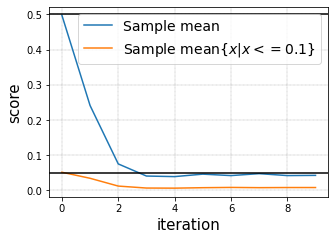

In [5]:
ax = ce.show_sampled_scores()
ax.axhline(0.5, color='k')
ax.axhline(0.05, color='k');

The CE class can also provide a summary of the process in both batch-level and sample-level:

In [6]:
d1, d2 = ce.get_data()

Batch level:
* `ref_quantile`: The value of $q$. In this case it is constant, but in the next example we define $q$ to be a quantile of the data, which may vary every iteration.
* `internal_quantile`: This is the $\rho$-quantile of the batch (i.e., the threshold that guarantees that at least $\rho$ samples will be used for the update). Note in the 3rd iteration, we already have `internal_quantile<ref_quantile`, i.e., the tail of the original distribution covers more than $\rho$ of the sampled batch, hence we can use even more samples for the update (`n_update_samples>500` and `update_samples_perc>0.5`).
* `beta_mean`: This is the parameter $\phi'$ of the sample distribution, whose name was defined in the CEM_Beta class above.

In [7]:
d1

,title,batch,ref_quantile,internal_quantile,n_update_samples,update_samples_perc,beta_mean
0,CEM,0,0.1,0.494668,500,50.0,0.500000
1,CEM,1,0.1,0.146594,500,50.0,0.246794
2,CEM,2,0.1,0.005251,781,78.1,0.076252
3,CEM,3,0.1,0.000196,883,88.3,0.044792
4,CEM,4,0.1,0.000030,897,89.7,0.040374
5,CEM,5,0.1,0.000180,872,87.2,0.045598
6,CEM,6,0.1,0.000165,879,87.9,0.045229
7,CEM,7,0.1,0.000200,855,85.5,0.049653
8,CEM,8,0.1,0.000156,878,87.8,0.046418
9,CEM,9,0.1,0.000201,884,88.4,0.046113


Sample level:
* `selected`: Whether the sample was used for the update of $\phi'$ (i.e., whether its score was below $q'$).
* `weight`: The IS weight of the sample. Note that the weight is $1$ in the first batch, and also in reference-samples in the following batches (in this example we don't have such reference-samples, but in the examples below we do).
* Note again that in the toy example, the `score` equals the `sample`, rather than being generated by some random process depending on that sample.

In [8]:
d2

,title,batch,sample_id,selected,weight,score,sample
0,CEM,0,0,0.0,1.000000,7.754505e-01,7.754505e-01
1,CEM,0,1,1.0,1.000000,9.076391e-02,9.076391e-02
2,CEM,0,2,0.0,1.000000,8.760137e-01,8.760137e-01
3,CEM,0,3,1.0,1.000000,1.292262e-01,1.292262e-01
4,CEM,0,4,0.0,1.000000,9.654643e-01,9.654643e-01
...,...,...,...,...,...,...,...
9995,CEM,9,995,1.0,0.478293,3.399393e-02,3.399393e-02
9996,CEM,9,996,1.0,0.309475,2.131991e-02,2.131991e-02
9997,CEM,9,997,1.0,0.320282,2.212332e-02,2.212332e-02
9998,CEM,9,998,1.0,0.018892,4.175095e-09,4.175095e-09


### Sampling below a quantile threshold

In the example above, we are interested in scores below $q=0.1$.
In many problems, however, the desired threshold is a quantile of the (possibly unknown) scores distribution.
For example, consider the $\alpha$-quantile for $\alpha=0.1$ in the same toy example.

Since the original distribution is $U([0,1))$ and the score is the sample itself, then in our toy example $q_\alpha(scores) = \alpha = 0.1$; that is, we essentially set the same sampling target as before.
However, this time the CEM is not aware to the explicit value of $q$, and has to infer it from the data.

The CEM module supports such a quantile threshold in two different modes:
* `ref_q=None, ref_mode='train', ref_alpha=alpha, n_orig_per_batch=something_positive`: Sample a part of every batch from the original distribution $D_{\phi_0}$ rather than the sample distribution $D_{\phi'}$, and estimate $q_\alpha$ (the $\alpha$-quantile) from that part of the batch. Note that we could have estimated $q_\alpha$ directly from $D_{\phi'}$ using Importance Sampling (IS) even without the reference-samples, but we found that estimation from such reference-samples is more numerically-stable - when the distributional shift is large and the IS weights have a high variance.
* `ref_q=None, ref_mode='valid', ref_alpha=alpha`: Estimate $q_\alpha$ from an external validation data assumed to be sampled from $D_{\phi_0}$. In this mode, `update_ref_scores(validation_scores)` must be called before the update.

Below we run the same toy example as above, but with $\alpha=0.1$ rather than $q=0.1$.
Evidently, the CEM manages to estimate the desired threshold and produce similar results.

Note that this time every batch also includes reference-samples drawn from the original distribution $D_{\phi_0}$ (20% of the batch by default, when `ref_q=None`). The method `show_sampled_scores()` presents these reference-samples separately.
The term $CVaR_\alpha$ in the legend refers to the *Conditional Value at Risk*, defined as the average over the lowest quantiles of a distribution, i.e., $CVaR_\alpha(X)=E[X | X\le q_\alpha(X)]$ (which is the same as in the figure above, but with the quantile-threshold $q=q_\alpha(X)$).

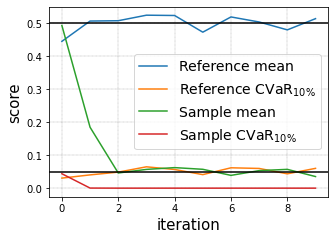

In [9]:
ce = CEM_Beta(phi0=0.5, batch_size=batch_size, min_batch_update=0.5, ref_mode='train', ref_alpha=0.1)

simulate_toy_process_and_sampling(ce)

# plot summary
ax = ce.show_sampled_scores()
ax.axhline(0.5, color='k')
ax.axhline(0.05, color='k');

### Optimization

To use the CEM for optimization in the toy example, we set:
* `ref_mode='none'`, so that the update will always use the bottom $\rho$ of the batch, with no limited target threshold.
* `w_clip=1`. This limits the IS weights to the range $[1/clip,\, clip]$. In a sampling task, `w_clip~10` may stabilize the updates in presence of extreme weights. In the current optimization task, `w_clip=1` simply enforces all the weights to equal $1$.

The CEM indeed converges to the optimum $\phi^*=0.001$ within 4 iterations (note that the definition of the CEM_Beta class above limits the range of $\phi'$ to $[0.001,0.999]$).

,title,batch,ref_quantile,internal_quantile,n_update_samples,update_samples_perc,beta_mean
0,CEM,0,-inf,4.947597e-01,500,50.0,0.500000
1,CEM,1,-inf,1.498160e-01,500,50.0,0.247996
2,CEM,2,-inf,8.369389e-05,500,50.0,0.044699
3,CEM,3,-inf,4.749605e-151,500,50.0,0.001000
4,CEM,4,-inf,2.464659e-154,500,50.0,0.001000
5,CEM,5,-inf,2.213509e-150,500,50.0,0.001000
6,CEM,6,-inf,2.510048e-151,500,50.0,0.001000
7,CEM,7,-inf,1.321303e-150,500,50.0,0.001000
8,CEM,8,-inf,5.055835e-149,500,50.0,0.001000
9,CEM,9,-inf,4.173535e-153,500,50.0,0.001000


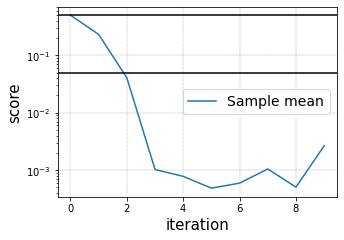

In [10]:
ce = CEM_Beta(phi0=0.5, batch_size=batch_size, min_batch_update=0.5, ref_mode='none', w_clip=1)

simulate_toy_process_and_sampling(ce)

# plot summary
ax = ce.show_sampled_scores()
ax.axhline(0.5, color='k')
ax.axhline(0.05, color='k')
ax.set_yscale('log')

# show batch-level info
ce.get_data()[0]

## Cross entropy sampler for risk-averse reinforcement learning

#### Motivation
For risk-averse reinforcement learning (RL), a common metric to optimize is the $CVaR_\alpha$ of the agent returns (instead of the expected return).
In a [separate work](https://github.com/ido90/CeSoR), we apply policy gradient wrt the CVaR metric.
Since the learning focuses on the worst episodes per batch, we use the CEM to sample more difficult episodes in the first place, which is shown to improve the sample-efficiency.

#### Problem definition
In this example, the **score function** of the CEM is the return $R(x; agent)$ of the agent in the gym-simulation of the RL environment, initialized with the environment conditions $x$.
The **threshold** is the $\alpha$-quantile of the original returns distribution (where $\alpha$ is defined by the CVaR target).
The **distributions class** can be defined according to the specific RL environment.

#### The dynamic reference challenge
The sampling problem is challenging in this case, since the "original" returns distribution (and its corresponding quantile $q_\alpha$) is not constant:
in the training process, we change not only the environment-sampling distribution $D_\phi$ but also the agent policy. Hence, the returns distribution corresponding to $D_{\phi_0}$ varies with the evolution of the agent.
Yet, the dynamic quantile estimation of our CEM module can handle this evolution.

#### Code
The code and the notebooks are available in the corresponding [repo](https://github.com/ido90/CeSoR), with examples in different RL problems: a maze, a self-driving task and a resource-management task.